## Denoising dentists using autoencoder 🦷
#### By: Fady Motir

In [96]:
import pandas as pd
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import os 
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

In [97]:
root_dir = "/kaggle/input/medical-image-dataset/Dataset/"

In [98]:
images_path = os.listdir(root_dir)
len(images_path)

120

In [99]:
images = []

for img_path in images_path:
    img = load_img(root_dir + img_path, target_size=(64,64), color_mode="grayscale")
    img = img_to_array(img)
    img = img / 255.0
    images.append(img)

In [100]:
images = np.array(images)
type(images)

numpy.ndarray

In [101]:
def visualize_df(df: np.ndarray):
    fig, axes = plt.subplots(4,4, figsize=(12,12))
    for i, ax in enumerate(axes.ravel()):
        if i < len(df):
            img = df[i]
            ax.imshow(img, cmap="gray")
            ax.axis("off")
        else:
            ax.axis("off")
    plt.tight_layout()
    plt.show()

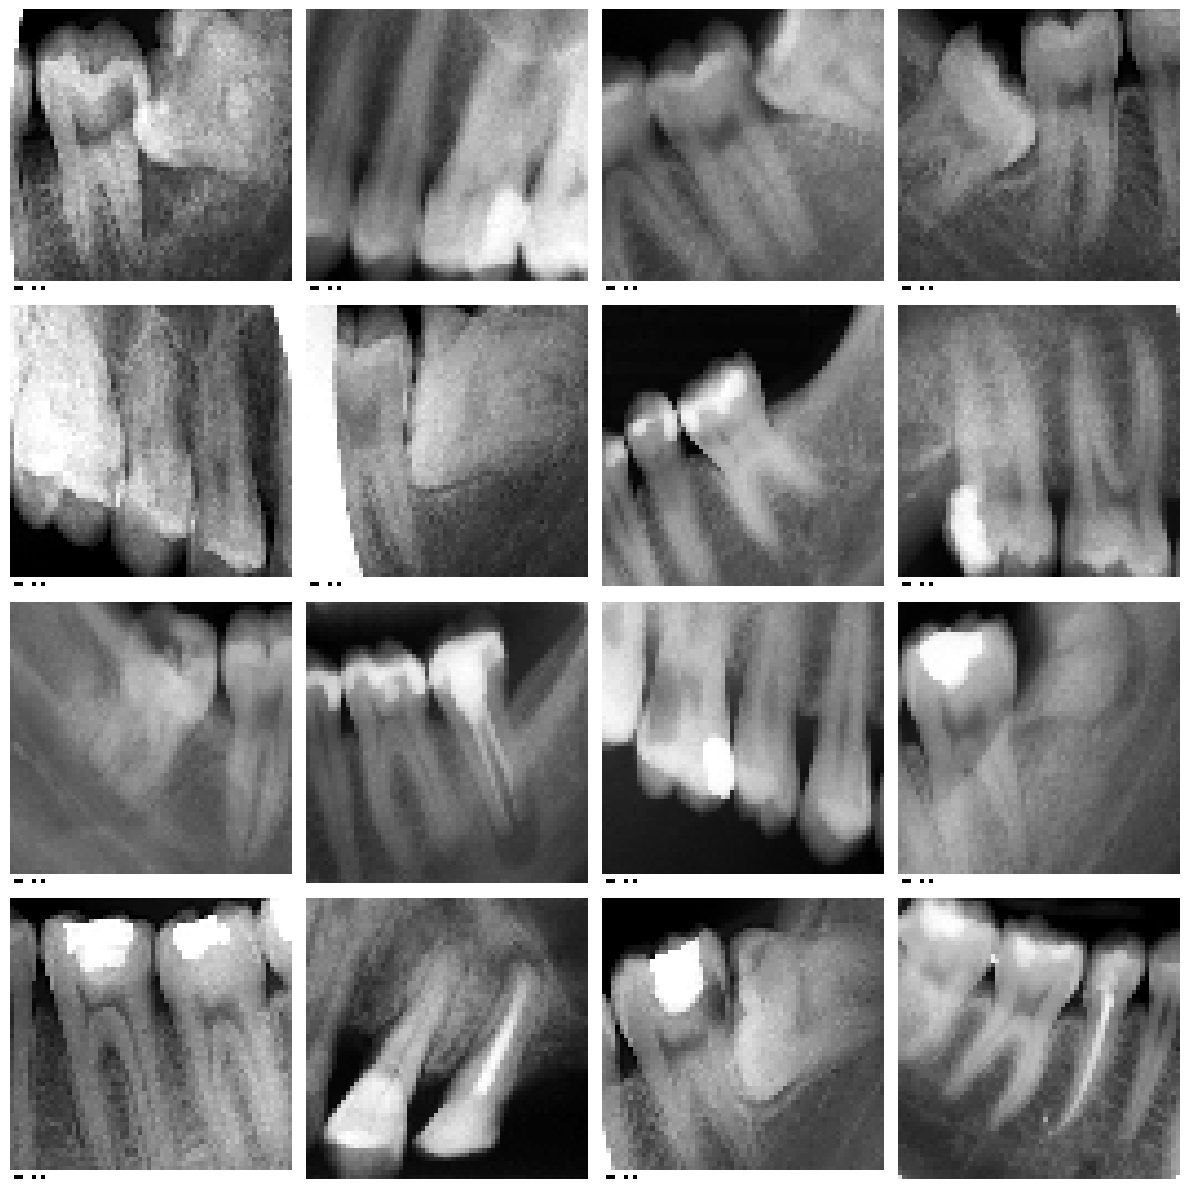

In [102]:
visualize_df(images)

In [103]:
# Create a function for adding a Noise to images
noise_factor = 0.2
noise_images = []

for image in images:
    noisy = image + noise_factor * np.random.randn(*image.shape)
    noisy = np.clip(noisy, 0.0, 1.0)
    noise_images.append(noisy)

In [104]:
noise_images = np.array(noise_images)

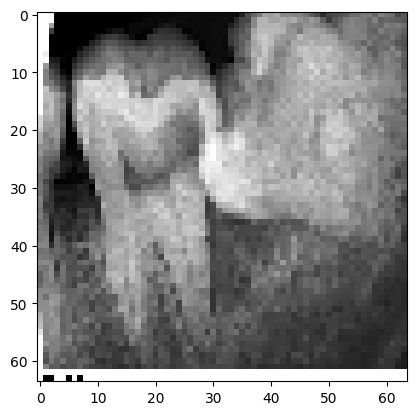

In [105]:
plt.imshow(images[0], cmap="gray") 

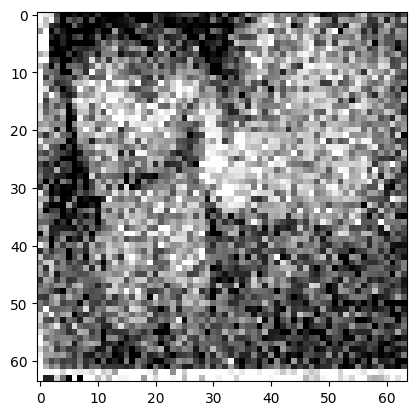

In [106]:
plt.imshow(noise_images[0], cmap="gray") 

In [107]:
# Splitting data to Train and Test 
noise_train = noise_images[:100]
noise_test = noise_images[100:]

print(noise_train.shape)
print(noise_test.shape)

(100, 64, 64, 1)
(20, 64, 64, 1)


In [108]:
normal_train = images[:100]
normal_test = images[100:]


print(normal_train.shape)
print(normal_test.shape)

(100, 64, 64, 1)
(20, 64, 64, 1)


## Model 🤖

In [109]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, Input, MaxPooling2D,MaxPool2D, UpSampling2D
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as k

def auto_encoder():
    input_img = Input(shape=(64,64,1), name = 'image_input')
    
    
    # Encoder
    x = Conv2D(64, (3,3), activation= 'relu', padding= 'same', name= 'Conv1')(input_img)
    x = MaxPooling2D((2,2),padding= 'same', name= 'pool1')(x)
    x = Conv2D(64, (3,3), activation= 'relu', padding= 'same', name= 'Conv2')(x)
    x = MaxPooling2D((2,2),padding= 'same', name= 'pool2')(x)
    
    
    # Decoder
    x = Conv2D(64, (3,3), activation= 'relu', padding= 'same', name= 'Conv3')(x)
    x = UpSampling2D((2,2),name= 'upsample1')(x)
    x = Conv2D(64, (3,3), activation= 'relu', padding= 'same', name= 'Conv4')(x)
    x = UpSampling2D((2,2),name= 'upsample2')(x)
    x = Conv2D(1, (3,3), activation= 'sigmoid', padding= 'same', name= 'Conv5')(x)
    
    
    # Model 
    auto_encoder = Model(inputs= input_img,outputs = x)
    auto_encoder.compile(optimizer='adam', loss= 'binary_crossentropy')
    
    return auto_encoder

In [110]:
model = auto_encoder()
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 64, 64, 1)]       0         
                                                                 
 Conv1 (Conv2D)              (None, 64, 64, 64)        640       
                                                                 
 pool1 (MaxPooling2D)        (None, 32, 32, 64)        0         
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 64)        36928     
                                                                 
 pool2 (MaxPooling2D)        (None, 16, 16, 64)        0         
                                                                 
 Conv3 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 upsample1 (UpSampling2D)    (None, 32, 32, 64)        0   

In [111]:
model.fit(noise_train, normal_train, 
          validation_data= (noise_test, normal_test),
          epochs= 50,
          batch_size= 128)

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.7042 - val_loss: 0.6915
Epoch 2/50
1/1 [==============================] - 0s 50ms/step - loss: 0.6920 - val_loss: 0.6882
Epoch 3/50
1/1 [==============================] - 0s 49ms/step - loss: 0.6894 - val_loss: 0.6854
Epoch 4/50
1/1 [==============================] - 0s 50ms/step - loss: 0.6855 - val_loss: 0.6827
Epoch 5/50
1/1 [==============================] - 0s 49ms/step - loss: 0.6816 - val_loss: 0.6763
Epoch 6/50
1/1 [==============================] - 0s 49ms/step - loss: 0.6752 - val_loss: 0.6680
Epoch 7/50
1/1 [==============================] - 0s 49ms/step - loss: 0.6668 - val_loss: 0.6592
Epoch 8/50
1/1 [==============================] - 0s 49ms/step - loss: 0.6562 - val_loss: 0.6444
Epoch 9/50
1/1 [==============================] - 0s 49ms/step - loss: 0.6415 - val_loss: 0.6315
Epoch 10/50
1/1 [==============================] - 0s 47ms/step - loss: 0.6270 - val_loss: 0.6302
Epoch 11/50
1/1 [==============

In [112]:
predicted = model.predict(noise_test)

1/1 [==============================] - 0s 83ms/step


In [113]:
evaluation = model.evaluate(noise_test, normal_test)
evaluation

1/1 [==============================] - 0s 25ms/step - loss: 0.5903


0.5903178453445435

In [114]:
from sklearn.metrics import mean_squared_error

# Calculate MSE
actual_values_flat = normal_test.flatten()
predicted_values_flat = predicted.flatten()

mse = mean_squared_error(actual_values_flat,predicted_values_flat)

print("Mean Squared Error (MSE) = ",mse)

Mean Squared Error (MSE) =  0.01223333


In [115]:
def plot_predictions(test, preds):
    plt.figure(figsize= (12,12))
    
    # Noise test
    for i in range(16):
        plt.subplot(4, 8, i+1)
        plt.imshow(test[i], cmap= 'gray')
        plt.axis('off')
        plt.title('Noised')
        
    # Predicted
    for i in range(16):
        plt.subplot(4, 8, i+17)
        plt.imshow(preds[i], cmap= 'gray')
        plt.axis('off')
        plt.title('Predicted')
        
    plt.show()    

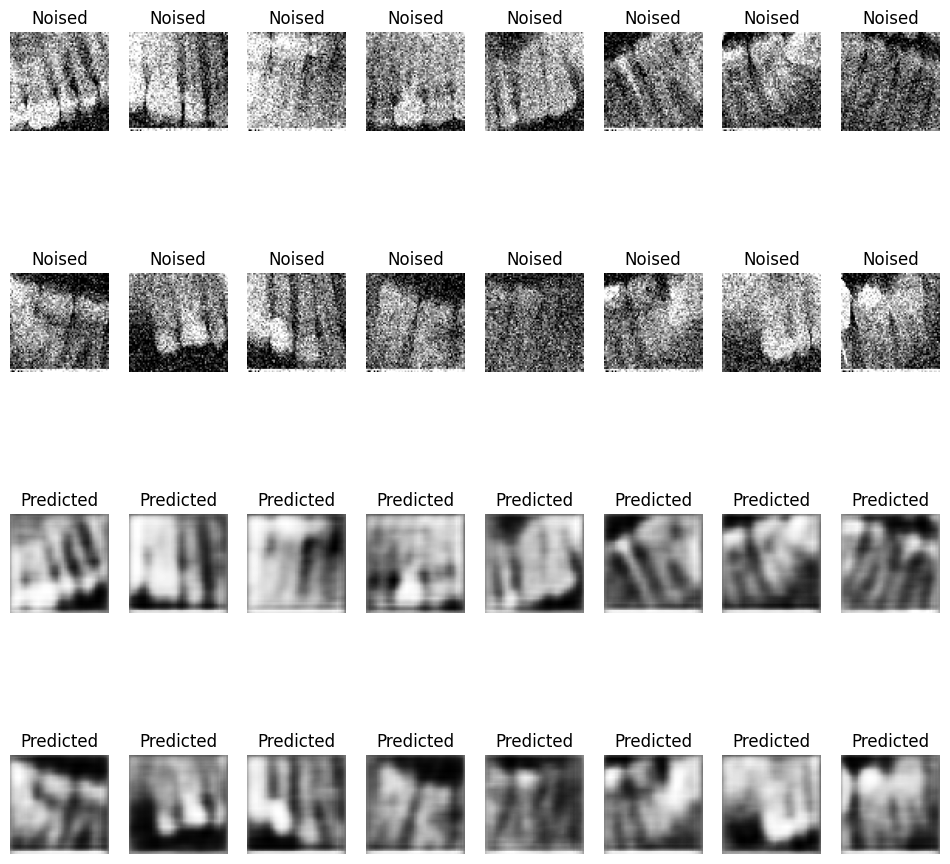

In [116]:
plot_predictions(noise_test, predicted)

In [117]:
# Enhanced Model Buliding

input_layer = Input(shape=(64,64,1))

# Encoder
x = Conv2D(32,(3,3), activation="relu", padding= "same")(input_layer)
x = MaxPooling2D((2,2), padding= "same")(x)
x = Conv2D(64,(3,3), activation="relu", padding= "same")(x)
encoded = MaxPooling2D((2,2), padding= "same")(x)

# Decoder
x = Conv2D(64,(3,3), activation="relu", padding= "same")(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(32,(3,3), activation="relu", padding= "same")(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1,(3,3), activation="sigmoid", padding= "same")(x)

autoencoder = Model(input_layer, decoded)

In [118]:
autoencoder.compile(optimizer= 'adam', loss= 'mean_squared_error')

In [119]:
autoencoder.fit(noise_train, normal_train, epochs= 50, batch_size= 128,
               shuffle= True, validation_data = (noise_test,noise_test))

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.0632 - val_loss: 0.0802
Epoch 2/50
1/1 [==============================] - 0s 40ms/step - loss: 0.0598 - val_loss: 0.0785
Epoch 3/50
1/1 [==============================] - 0s 41ms/step - loss: 0.0579 - val_loss: 0.0763
Epoch 4/50
1/1 [==============================] - 0s 43ms/step - loss: 0.0551 - val_loss: 0.0745
Epoch 5/50
1/1 [==============================] - 0s 43ms/step - loss: 0.0525 - val_loss: 0.0713
Epoch 6/50
1/1 [==============================] - 0s 43ms/step - loss: 0.0489 - val_loss: 0.0665
Epoch 7/50
1/1 [==============================] - 0s 43ms/step - loss: 0.0440 - val_loss: 0.0622
Epoch 8/50
1/1 [==============================] - 0s 41ms/step - loss: 0.0392 - val_loss: 0.0580
Epoch 9/50
1/1 [==============================] - 0s 41ms/step - loss: 0.0339 - val_loss: 0.0526
Epoch 10/50
1/1 [==============================] - 0s 40ms/step - loss: 0.0278 - val_loss: 0.0493
Epoch 11/50
1/1 [==============

In [120]:
predicted = autoencoder.predict(noise_test)

1/1 [==============================] - 0s 86ms/step


In [121]:
evaluation = model.evaluate(noise_test, normal_test)
evaluation

1/1 [==============================] - 0s 26ms/step - loss: 0.5903


0.5903178453445435

In [122]:
from sklearn.metrics import mean_squared_error

# Calculate MSE
actual_values_flat = normal_test.flatten()
predicted_values_flat = predicted.flatten()

mse = mean_squared_error(actual_values_flat,predicted_values_flat)

print("Mean Squared Error (MSE) = ",mse)

Mean Squared Error (MSE) =  0.011660414


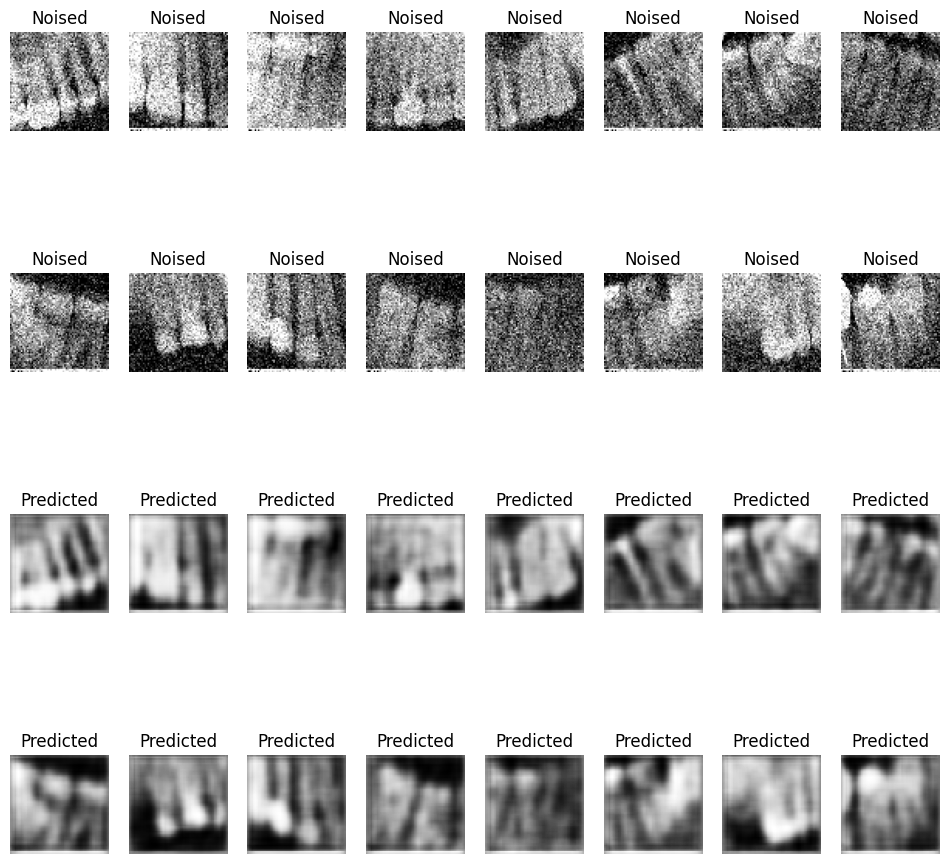

In [123]:
plot_predictions(noise_test, predicted)